In [ ]:
# connecting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dependencies
import os
from PIL import Image
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
!pip install transformers

from transformers import DetrForObjectDetection, DetrImageProcessor

model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2446: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

# Data Extraction

In [ ]:
# import the dataset
PROJECT_ROOT = "/content/drive/MyDrive/COS429/cv_final_project"
DATASET_ROOT = os.path.join(PROJECT_ROOT, "archive")

In [ ]:
print(os.listdir(DATASET_ROOT))

['Val', 'Test', 'Train']


In [ ]:
def get_split_dirs(split):
    """
    split: 'train', 'val', or 'test'
    Returns: (images_dir, annots_dir, list_file)
    """
    # Adjust for capitalized 'Train' directory
    if split == 'train':
        split_root = os.path.join(DATASET_ROOT, 'Train')
    elif split == 'val':
        split_root = os.path.join(DATASET_ROOT, 'Val')
    else:
        split_root = os.path.join(DATASET_ROOT, 'Test')

    images_dir = os.path.join(split_root, split.capitalize(), "JPEGImages") # because dataset structure is ex: Train/Train/...
    annots_dir = os.path.join(split_root, split.capitalize(), "Annotations")
    list_file = os.path.join(split_root, split.capitalize(), f"{split}.txt")
    return images_dir, annots_dir, list_file

for s in ["train", "val", "test"]:
    images_dir, annots_dir, list_file = get_split_dirs(s)
    print(f"{s} images dir:    {images_dir}")
    print(f"{s} annots dir:    {annots_dir}")
    print(f"{s} list file:     {list_file}")
    print()

RESULTS_DIR = os.path.join(PROJECT_ROOT, "results_detr")
os.makedirs(RESULTS_DIR, exist_ok=True)
print("Results will be saved to:", RESULTS_DIR)

train images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages
train annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/Annotations
train list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/train.txt

val images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/JPEGImages
val annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/Annotations
val list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Val/Val/val.txt

test images dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/JPEGImages
test annots dir:    /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/Annotations
test list file:     /content/drive/MyDrive/COS429/cv_final_project/archive/Test/Test/test.txt

Results will be saved to: /content/drive/MyDrive/COS429/cv_final_project/results_detr


In [ ]:
def parse_annotation(xml_path):
    """
    Parse a VOC-style XML file.

    Returns list of dicts:
      [{ 'bbox': (xmin,ymin,xmax,ymax), 'label': str }, ...]
    """
    import xml.etree.ElementTree as ET

    tree = ET.parse(xml_path)
    root = tree.getroot()

    objects = []
    for obj in root.findall('object'):
        name = obj.find('name').text.lower().strip() # tag / label
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        objects.append({
            'label': name,
            'bbox': (xmin, ymin, xmax, ymax),
        })
    return objects


In [ ]:
person_labels    = {'person'}
nonperson_labels = {'person-like'}

def map_label_to_binary(name):
    """
    Returns 1 for person, 0 for non-person, or None to ignore.
    """
    name = name.lower()
    if name in person_labels:
        return 1
    if name in nonperson_labels:
        return 0
    print("there's a third label called ", name)
    return None


def resolve_image_path(images_dir, base_id):
    """
    base_id is like 'image (7)' from train.txt / val.txt / test.txt.
    """
    ext = ".jpg"

    candidate = os.path.join(images_dir, base_id + ext)
    if os.path.exists(candidate):
      return candidate
    return None

# Import tqdm for progress bar
from tqdm.notebook import tqdm

def load_split_samples(split):
    """
    Load all bounding boxes for a given split ('train', 'val', 'test').

    Returns: list of dicts with keys:
      'img_path', 'bbox', 'label', 'y', 'split'
    """
    images_dir, annots_dir, list_file = get_split_dirs(split)

    # Load list of image IDs from txt file (e.g. 'image (7)')
    with open(list_file, 'r') as f:
        ids = [line.strip() for line in f if line.strip()]

    samples_grouped = [] # List to store grouped samples
    total_positives = 0
    total_negatives = 0

    # Wrap the iteration with tqdm to show progress
    for img_id in tqdm(ids, desc=f'Loading {split} samples'):
        base = os.path.splitext(img_id)[0]  # strip extension if present

        # Resolve xml path using base id
        xml_path = os.path.join(annots_dir, base + ".xml")
        if not os.path.exists(xml_path):
            # print(f"[{split}] Warning: XML not found for", xml_path)
            continue

        objs = parse_annotation(xml_path)

        # Resolve image path using base id (ignore XML filename)
        img_path = resolve_image_path(images_dir, base)
        if img_path is None:
            print(f"[{split}] Warning: no image found for ID '{base}'")
            continue

        current_image_annotations = []
        # for each of the bounding boxes
        for o in objs:
            y = map_label_to_binary(o['label'])
            if y is None:
                continue  # skip labels we don't care about

            current_image_annotations.append({
                'bbox': o['bbox'],
                'label': o['label'],
                'y': y, # 1 if person, 0 if non-person label
            })
            if y == 1:
                total_positives += 1
            else:
                total_negatives += 1

        if current_image_annotations:
            samples_grouped.append({
                'img_path': img_path,
                'split': split,
                'annotations': current_image_annotations,
            })

    print(f"{split}: loaded {len(samples_grouped)} images with annotations")
    print(f"  total positives (person):     {total_positives}")
    print(f"  total negatives (non-person): {total_negatives}")
    return samples_grouped

**Reasoning**:
Now that the `load_split_samples` function has been modified, I need to call it again for each split (train, validation, and test) to update the `train_samples`, `val_samples`, and `test_samples` variables with the new grouped data structure. This will apply the changes and make the new data format available for subsequent steps.



In [ ]:
train_samples = load_split_samples("train")
val_samples   = load_split_samples("val")
test_samples  = load_split_samples("test")

labels_in_data = sorted({label for sample_group in (train_samples + val_samples + test_samples) for annotation in sample_group['annotations'] for label in [annotation['label']]})
print("Labels present across all splits:", labels_in_data)

Loading train samples:   0%|          | 0/944 [00:00<?, ?it/s]

train: loaded 944 images with annotations
  total positives (person):     1106
  total negatives (non-person): 960


Loading val samples:   0%|          | 0/160 [00:00<?, ?it/s]

val: loaded 160 images with annotations
  total positives (person):     203
  total negatives (non-person): 130


Loading test samples:   0%|          | 0/235 [00:00<?, ?it/s]

test: loaded 235 images with annotations
  total positives (person):     317
  total negatives (non-person): 278
Labels present across all splits: ['person', 'person-like']


**Reasoning**:
The previous step updated the `load_split_samples` function and reloaded the data. Now, I need to verify that the `train_samples` variable holds the new grouped data structure as intended. Printing the first sample from `train_samples` will allow for quick inspection of its keys and nested annotations.



In [ ]:
print(train_samples[0])

{'img_path': '/content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages/image (1).jpg', 'split': 'train', 'annotations': [{'bbox': (158, 44, 289, 167), 'label': 'person', 'y': 1}]}


{'img_path': '/content/drive/MyDrive/COS429/cv_final_project/archive/Train/Train/JPEGImages/image (111).jpg', 'split': 'train', 'annotations': [{'bbox': (3, 1, 351, 500), 'label': 'person', 'y': 1}]}


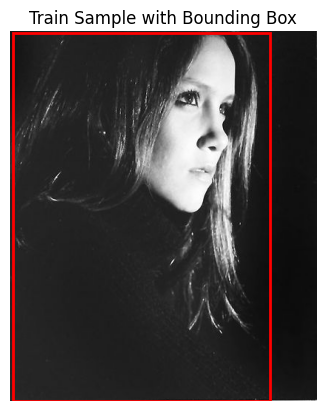

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Get the first sample from train_samples
sample = train_samples[14] # Using the same index as before to maintain context
print(sample)

# Load the image
image = Image.open(sample['img_path'])

# Create a figure and an axes object
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Iterate through all annotations and draw each bounding box
for annotation in sample['annotations']:
    xmin, ymin, xmax, ymax = annotation['bbox']
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                             linewidth=2,
                             edgecolor='r',
                             facecolor='none')
    ax.add_patch(rect)

# Turn off axis ticks
ax.axis('off')

# Set title
ax.set_title('Train Sample with Bounding Box')

# Display the plot
plt.show()

# Training Detr Model

In [ ]:
import torch
from transformers import DetrImageProcessor
from PIL import Image

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

class PedestrianDETRDataset(torch.utils.data.Dataset):
    def __init__(self, samples, processor, debug=False):
        self.samples = samples
        self.processor = processor
        self.debug = debug

        print(f"[INIT] Loaded {len(samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample["img_path"]).convert("RGB")
        anns  = sample["annotations"]

        # Build COCO-style annotations
        coco_ann_list = []
        for a in anns:
            xmin, ymin, xmax, ymax = a["bbox"]
            w = xmax - xmin
            h = ymax - ymin
            coco_ann_list.append({
                "bbox": [xmin, ymin, w, h],
                "category_id": a["y"],
                "area": w * h,
                "iscrowd": 0
            })
        coco_dict = {"image_id": idx, "annotations": coco_ann_list}

        # Processor: resize all images to fixed size (e.g., 800x800)
        encoding = self.processor(
            images=image,
            annotations=coco_dict,
            size={"height": 800, "width": 800},  # fixed size
            return_tensors="pt"
        )

        # Remove batch dimension added by processor
        encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
        encoding["pixel_mask"]   = encoding["pixel_mask"].squeeze(0)

        return encoding

In [ ]:
def show_example(dataset, index=0):
    print("EXAMPLE OUTPUT")
    item = dataset[index]
    print("Keys in returned dict:", item.keys())
    print("\npixel_values shape:", item["pixel_values"].shape)

    labels = item["labels"][0]
    print("\nlabels keys:", labels.keys())
    print("\nclass_labels:", labels["class_labels"])
    print("\nboxes (normalized 0–1):")
    print(labels["boxes"])


# Create dataset in debug mode for first sample only:
train_dataset_debug = PedestrianDETRDataset(train_samples, processor, debug=True)

# Show example of transformed sample:
show_example(train_dataset_debug, 0)


[INIT] Loaded 944 samples


========== EXAMPLE OUTPUT ==========

Keys in returned dict: KeysView({'pixel_values': tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  1.3584,  1.3755,  1.3755],
         [ 2.2489,  2.2489,  2.2489,  ...,  1.3584,  1.3584,  1.3584],
         [ 2.2489,  2.2489,  2.2489,  ...,  1.3584,  1.3413,  1.3413],
         ...,
         [ 1.1358,  1.1358,  1.1529,  ..., -0.3369, -0.2171, -0.1143],
         [ 1.0159,  1.0159,  1.0331,  ..., -0.6623, -0.5767, -0.5082],
         [ 0.9303,  0.9474,  0.9646,  ..., -0.8507, -0.7993, -0.7479]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  1.5707,  1.5882,  1.5882],
         [ 2.4286,  2.4286,  2.4286,  ...,  1.5707,  1.5707,  1.5707],
         [ 2.4286,  2.4286,  2.4286,  ...,  1.5707,  1.5532,  1.5532],
         ...,
         [ 1.0455,  1.0455,  1.0630,  ..., -0.3025, -0.1625, -0.0399],
         [ 0.9230,  0.9230,  0.9405,  ..., -0.6352, -0.5301, -0.4426],
         [ 0.8354,  0.8529,  0.8704,  ..., -0.8277, -0.7577, -0.6877]],

 

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    pixel_mask   = torch.stack([item["pixel_mask"] for item in batch])
    labels       = [item["labels"][0] for item in batch]

    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "labels": labels
    }

train_dataset = PedestrianDETRDataset(train_samples, processor)
val_dataset   = PedestrianDETRDataset(val_samples, processor)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


[INIT] Loaded 944 samples
[INIT] Loaded 160 samples


In [ ]:
from transformers import DetrForObjectDetection

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50",
    num_labels=2,
    ignore_mismatched_sizes=True
)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [ ]:
import torch
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)


In [ ]:
from tqdm.auto import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

num_epochs = 25

for epoch in range(num_epochs):
    print(f"\Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0.0
    total_cls  = 0.0
    total_bbox = 0.0
    total_giou = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in progress_bar:
        pixel_values = batch["pixel_values"].to(device)
        pixel_mask   = batch["pixel_mask"].to(device)
        labels       = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            labels=labels
        )

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        # extract individual losses
        cls_loss  = loss_dict.get("loss_ce", 0.0)
        bbox_loss = loss_dict.get("loss_bbox", 0.0)
        giou_loss = loss_dict.get("loss_giou", 0.0)

        total_loss += loss.item()
        total_cls  += float(cls_loss)
        total_bbox += float(bbox_loss)
        total_giou += float(giou_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update progress bar text
        progress_bar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "cls": f"{float(cls_loss):.4f}",
            "bbox": f"{float(bbox_loss):.4f}",
            "giou": f"{float(giou_loss):.4f}",
        })

    # Print per-epoch summary
    num_batches = len(train_loader)
    print(f"\n Epoch Summary {epoch+1}/{num_epochs}")
    print(f"  Total Loss:   {total_loss/num_batches:.4f}")
    print(f"  CE Loss:      {total_cls/num_batches:.4f}")
    print(f"  BBox Loss:    {total_bbox/num_batches:.4f}")
    print(f"  GIoU Loss:    {total_giou/num_batches:.4f}")


===== Epoch 1/25 =====


Epoch 1:   0%|          | 0/236 [00:00<?, ?it/s]

/tmp/ipython-input-102743683.py:39: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  total_cls  += float(cls_loss)



 Epoch Summary 1/25
  Total Loss:   1.1764
  CE Loss:      0.7286
  BBox Loss:    0.0445
  GIoU Loss:    0.1126

===== Epoch 2/25 =====


Epoch 2:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 2/25
  Total Loss:   0.9283
  CE Loss:      0.5273
  BBox Loss:    0.0396
  GIoU Loss:    0.1014

===== Epoch 3/25 =====


Epoch 3:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 3/25
  Total Loss:   0.8778
  CE Loss:      0.4757
  BBox Loss:    0.0396
  GIoU Loss:    0.1019

===== Epoch 4/25 =====


Epoch 4:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 4/25
  Total Loss:   0.9386
  CE Loss:      0.4653
  BBox Loss:    0.0474
  GIoU Loss:    0.1182

===== Epoch 5/25 =====


Epoch 5:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 5/25
  Total Loss:   1.0794
  CE Loss:      0.4685
  BBox Loss:    0.0643
  GIoU Loss:    0.1448

===== Epoch 6/25 =====


Epoch 6:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 6/25
  Total Loss:   0.8864
  CE Loss:      0.4115
  BBox Loss:    0.0482
  GIoU Loss:    0.1169

===== Epoch 7/25 =====


Epoch 7:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 7/25
  Total Loss:   0.8413
  CE Loss:      0.3912
  BBox Loss:    0.0453
  GIoU Loss:    0.1117

===== Epoch 8/25 =====


Epoch 8:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 8/25
  Total Loss:   0.8039
  CE Loss:      0.3728
  BBox Loss:    0.0432
  GIoU Loss:    0.1075

===== Epoch 9/25 =====


Epoch 9:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 9/25
  Total Loss:   0.7722
  CE Loss:      0.3496
  BBox Loss:    0.0419
  GIoU Loss:    0.1067

===== Epoch 10/25 =====


Epoch 10:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 10/25
  Total Loss:   0.7201
  CE Loss:      0.2999
  BBox Loss:    0.0427
  GIoU Loss:    0.1034

===== Epoch 11/25 =====


Epoch 11:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 11/25
  Total Loss:   0.6879
  CE Loss:      0.2805
  BBox Loss:    0.0409
  GIoU Loss:    0.1016

===== Epoch 12/25 =====


Epoch 12:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 12/25
  Total Loss:   0.7670
  CE Loss:      0.3050
  BBox Loss:    0.0466
  GIoU Loss:    0.1146

===== Epoch 13/25 =====


Epoch 13:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 13/25
  Total Loss:   0.7095
  CE Loss:      0.2763
  BBox Loss:    0.0435
  GIoU Loss:    0.1078

===== Epoch 14/25 =====


Epoch 14:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 14/25
  Total Loss:   0.6965
  CE Loss:      0.2666
  BBox Loss:    0.0427
  GIoU Loss:    0.1081

===== Epoch 15/25 =====


Epoch 15:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 15/25
  Total Loss:   0.6763
  CE Loss:      0.2511
  BBox Loss:    0.0433
  GIoU Loss:    0.1044

===== Epoch 16/25 =====


Epoch 16:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 16/25
  Total Loss:   0.6486
  CE Loss:      0.2273
  BBox Loss:    0.0423
  GIoU Loss:    0.1049

===== Epoch 17/25 =====


Epoch 17:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 17/25
  Total Loss:   0.5999
  CE Loss:      0.2073
  BBox Loss:    0.0389
  GIoU Loss:    0.0989

===== Epoch 18/25 =====


Epoch 18:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 18/25
  Total Loss:   0.5970
  CE Loss:      0.1969
  BBox Loss:    0.0397
  GIoU Loss:    0.1009

===== Epoch 19/25 =====


Epoch 19:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 19/25
  Total Loss:   0.6026
  CE Loss:      0.1959
  BBox Loss:    0.0411
  GIoU Loss:    0.1006

===== Epoch 20/25 =====


Epoch 20:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 20/25
  Total Loss:   0.5827
  CE Loss:      0.1869
  BBox Loss:    0.0398
  GIoU Loss:    0.0983

===== Epoch 21/25 =====


Epoch 21:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 21/25
  Total Loss:   0.5495
  CE Loss:      0.1728
  BBox Loss:    0.0378
  GIoU Loss:    0.0938

===== Epoch 22/25 =====


Epoch 22:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 22/25
  Total Loss:   0.5758
  CE Loss:      0.1886
  BBox Loss:    0.0389
  GIoU Loss:    0.0964

===== Epoch 23/25 =====


Epoch 23:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 23/25
  Total Loss:   0.6344
  CE Loss:      0.2077
  BBox Loss:    0.0436
  GIoU Loss:    0.1044

===== Epoch 24/25 =====


Epoch 24:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 24/25
  Total Loss:   0.6169
  CE Loss:      0.1902
  BBox Loss:    0.0430
  GIoU Loss:    0.1060

===== Epoch 25/25 =====


Epoch 25:   0%|          | 0/236 [00:00<?, ?it/s]


 Epoch Summary 25/25
  Total Loss:   0.7819
  CE Loss:      0.2383
  BBox Loss:    0.0551
  GIoU Loss:    0.1340


In [ ]:
model.eval()


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [ ]:
model_save_path = os.path.join(RESULTS_DIR, "detr.pth")
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/COS429/cv_final_project/results_detr/detr.pth


In [ ]:
test_dataset = PedestrianDETRDataset(test_samples, processor)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

[INIT] Loaded 235 samples


In [ ]:
!pip install torchmetrics

import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm.auto import tqdm
from transformers import DetrImageProcessor
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import random

# Re-initialize processor to be safe
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 54.6 MB/s eta 0:00:00


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [ ]:
def run_master_inference(model, test_samples, device):
    model.eval()
    results = []

    print(f"Starting inference on {len(test_samples)} images...")

    with torch.no_grad():
        for sample in tqdm(test_samples, desc="Inference Progress"):
            # prepare image
            try:
                img = Image.open(sample["img_path"]).convert("RGB")
            except Exception as e:
                print(f"Error loading {sample['img_path']}: {e}")
                continue

            encoding = processor(images=img, return_tensors="pt").to(device)

            outputs = model(**encoding)

            # post-process (get standard boxes in pizels)
            target_sizes = torch.tensor([img.size[::-1]]) # (H, W)
            post_processed = processor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]

            gt_boxes = []
            gt_labels_binary = []
            gt_labels_str = []

            for ann in sample["annotations"]:
                xmin, ymin, xmax, ymax = ann["bbox"]
                gt_boxes.append([xmin, ymin, xmax, ymax])
                gt_labels_binary.append(ann["y"])
                gt_labels_str.append(ann["label"])

            results.append({
                "img_path": sample["img_path"],
                "original_size": img.size, # (W, H)

                "pred": {
                    "boxes": post_processed["boxes"].cpu(),
                    "scores": post_processed["scores"].cpu(),
                    "labels": post_processed["labels"].cpu(),
                },

                "raw_logits": outputs.logits.cpu().squeeze(0), # (100, num_classes+1)

                "gt": {
                    "boxes": torch.tensor(gt_boxes, dtype=torch.float32),
                    "labels": torch.tensor(gt_labels_binary, dtype=torch.int64),
                    "labels_str": gt_labels_str
                }
            })

    return results

In [ ]:
all_results = run_master_inference(model, test_samples, device)
print(f"Master inference complete. Collected results for {len(all_results)} images.")

Starting inference on 235 images...


Inference Progress:   0%|          | 0/235 [00:00<?, ?it/s]

Master inference complete. Collected results for 235 images.


## Plot results


Visualizing random test samples...


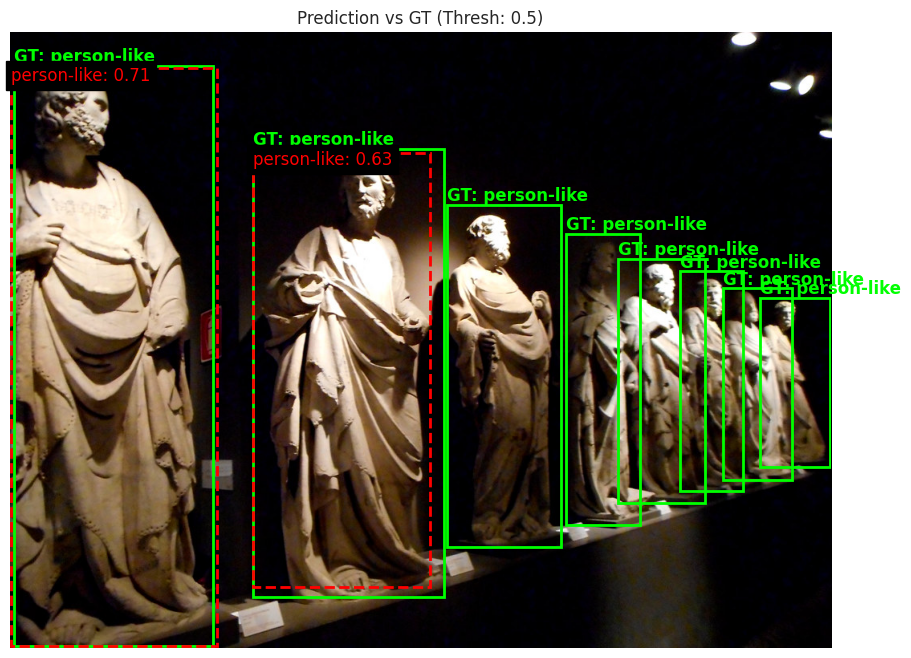

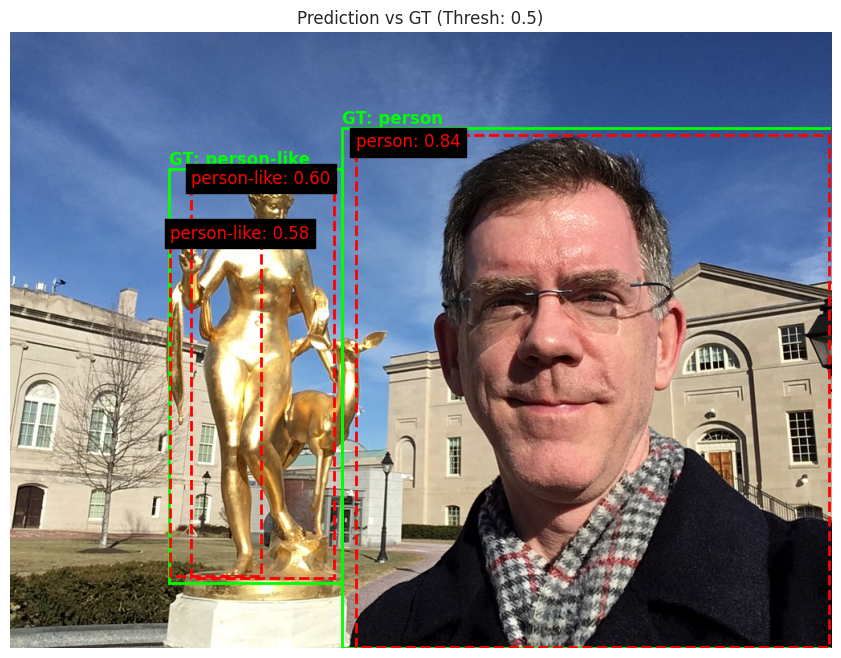

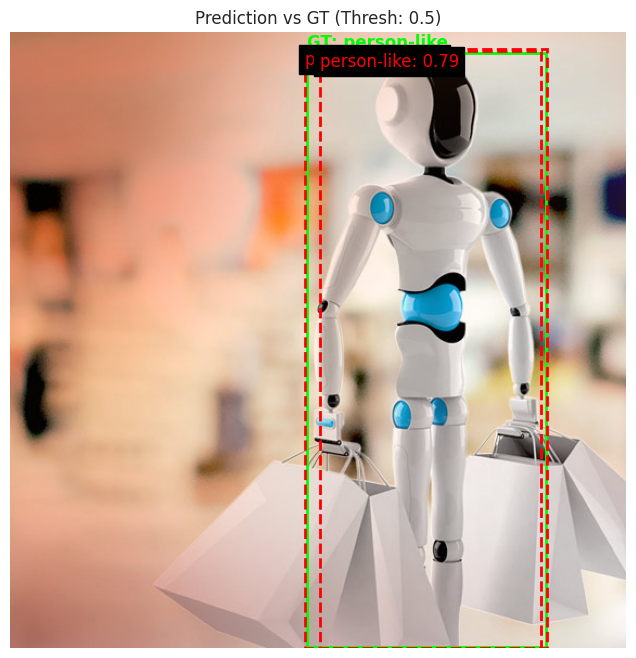

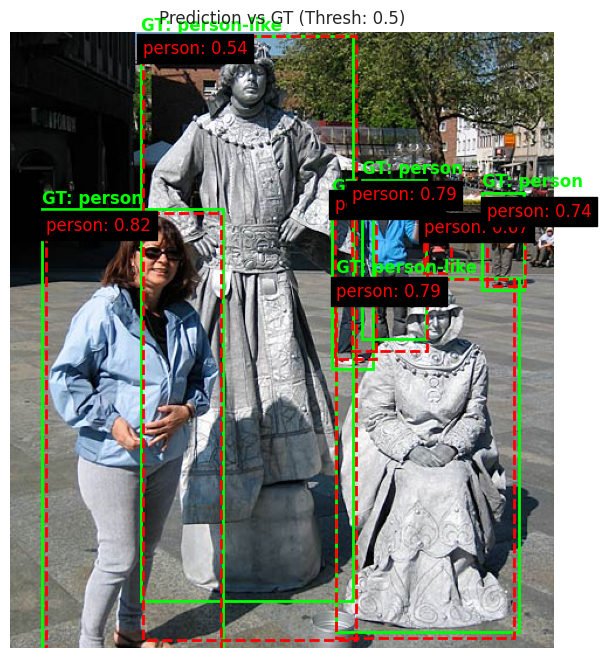

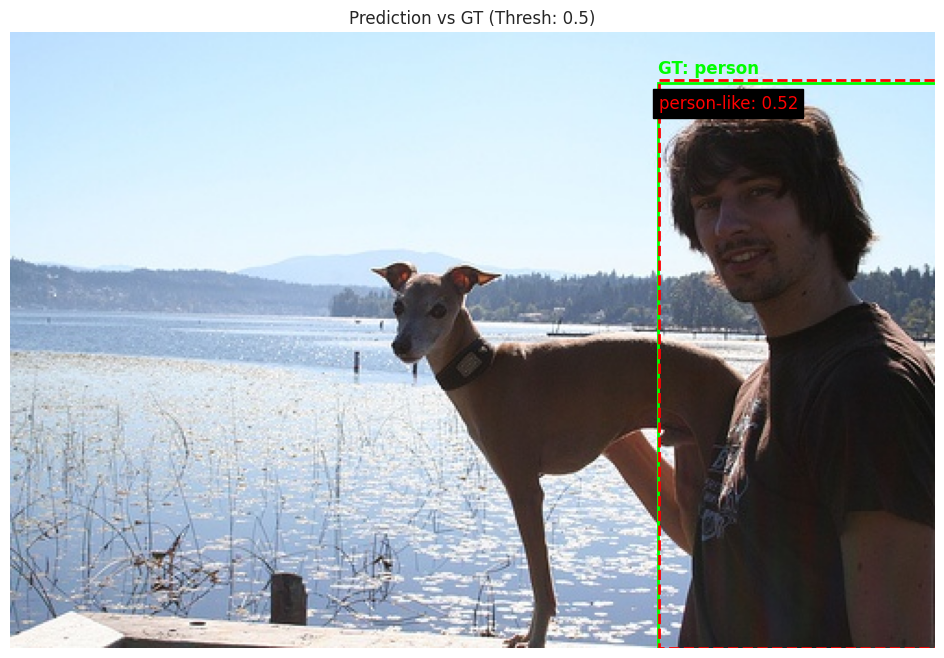

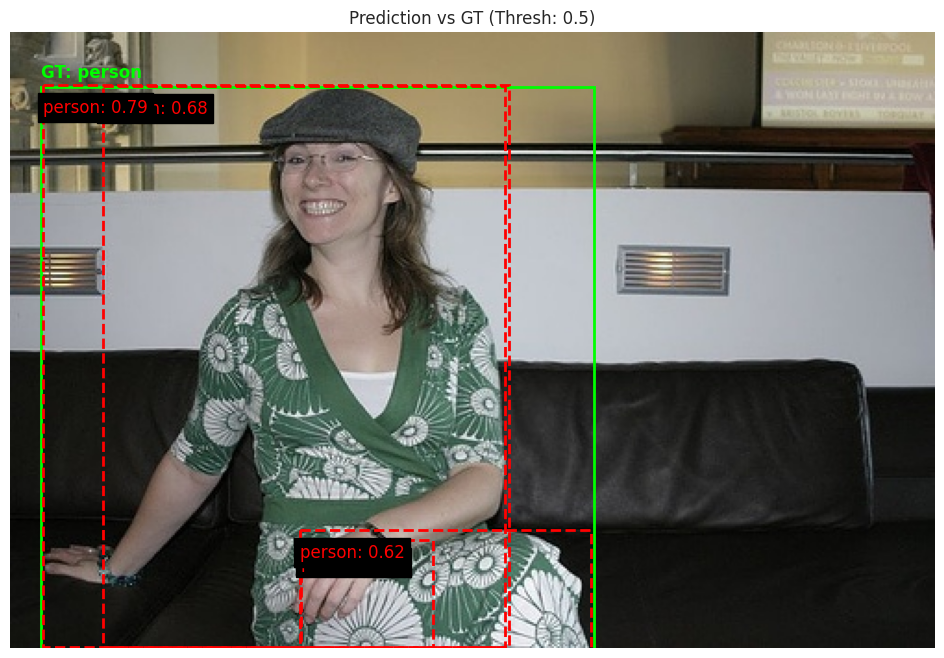

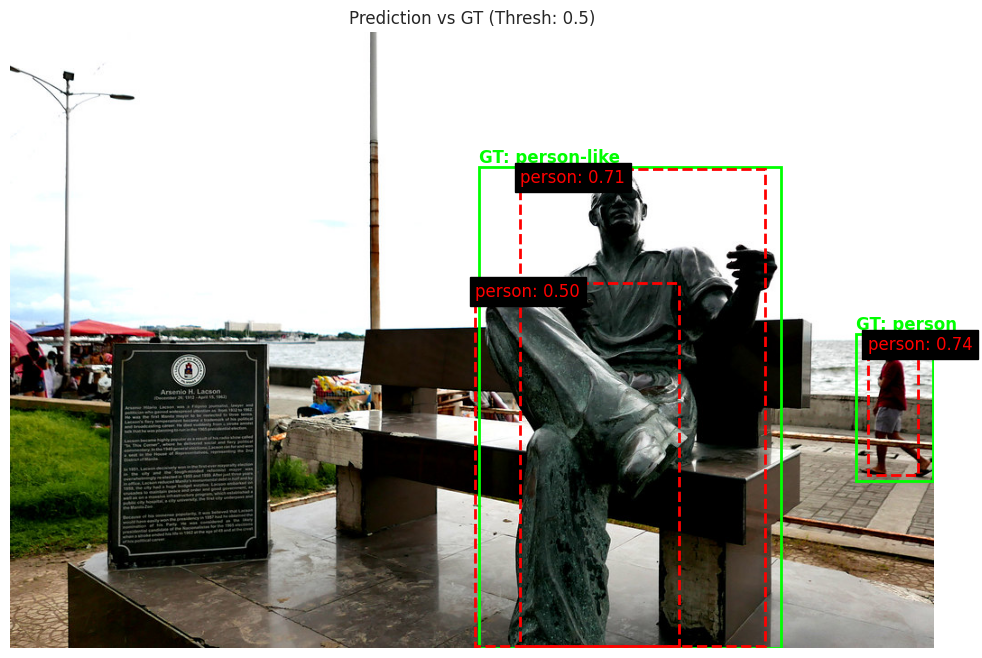

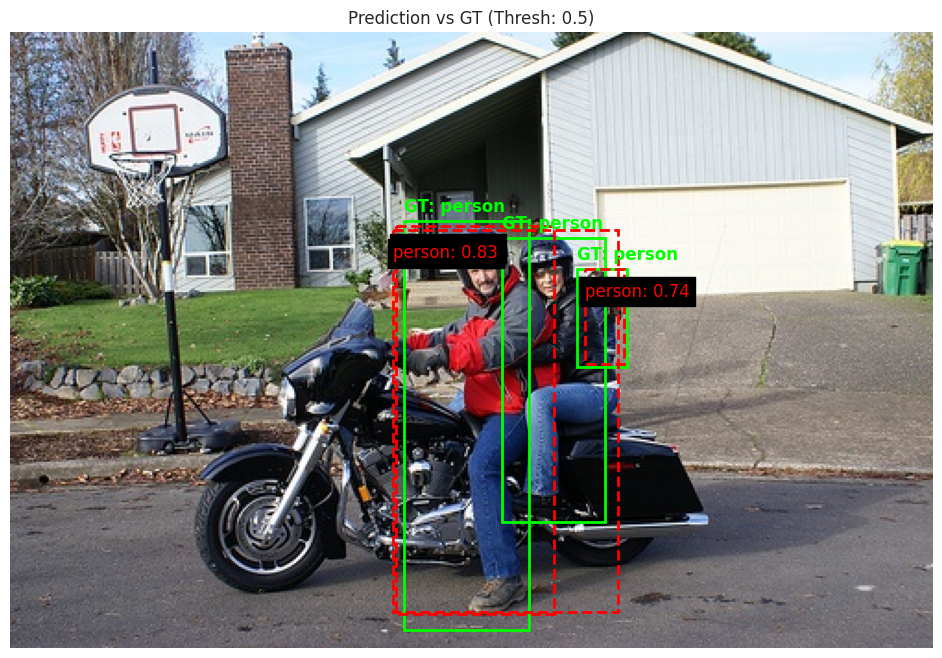

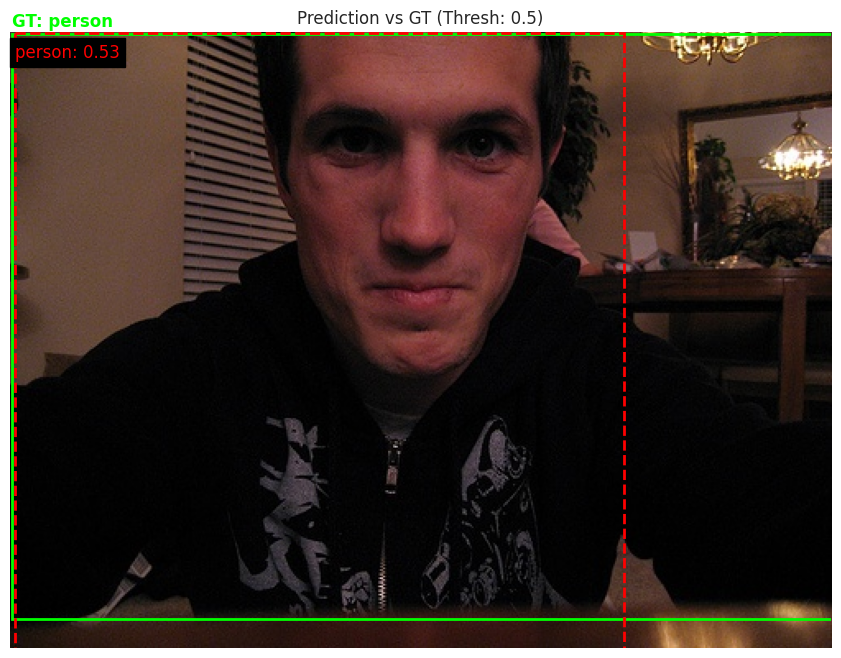

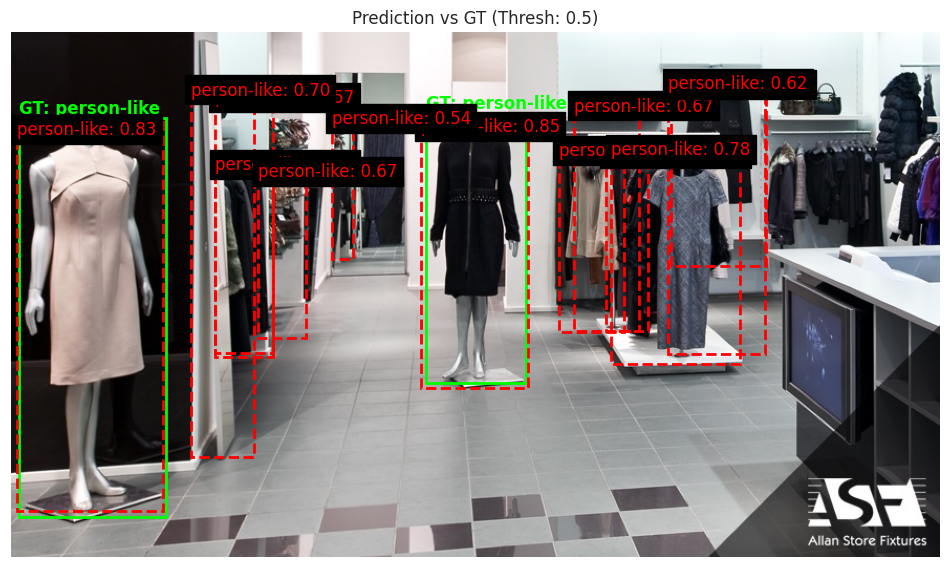

In [ ]:
labels_map = {0: "person-like", 1: "person"}

def plot_results(item, score_threshold=0.5):
    """
    Plots a single image with GT (Green) and Predictions (Red).
    """
    img = Image.open(item["img_path"]).convert("RGB")
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    ax = plt.gca()

    # Plot Ground Truth (Green Solid Line)
    for box, label in zip(item["gt"]["boxes"], item["gt"]["labels_str"]):
        x1, y1, x2, y2 = box.tolist()
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='lime', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f"GT: {label}", color='lime', fontweight='bold')

    # Plot Predictions (Red Dashed Line)
    keep = item["pred"]["scores"] > score_threshold
    pred_boxes = item["pred"]["boxes"][keep]
    pred_scores = item["pred"]["scores"][keep]
    pred_labels = item["pred"]["labels"][keep]

    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        x1, y1, x2, y2 = box.tolist()
        w, h = x2 - x1, y2 - y1
        label_name = labels_map.get(label.item(), str(label.item()))

        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(x1, y1+15, f"{label_name}: {score:.2f}", color='red', backgroundcolor='black')

    plt.axis('off')
    plt.title(f"Prediction vs GT (Thresh: {score_threshold})")
    plt.show()

# Show random examples
print("\nVisualizing random test samples...")
indices = random.sample(range(len(all_results)), min(10, len(all_results)))
for i in indices:
    plot_results(all_results[i])

In [ ]:
# mAP EVALUATION
print("\nComputing mAP (Mean Average Precision)...")

# Initialize Metric
metric = MeanAveragePrecision(box_format='xyxy', class_metrics=True)

formatted_preds = []
formatted_targets = []

for item in all_results:
    # Filter low confidence predictions to speed up calculation
    # DETR outputs 100 boxes; we usually only care about those > 5% confidence for metrics
    p = item["pred"]
    keep = p["scores"] > 0.05

    formatted_preds.append({
        "boxes": p["boxes"][keep],
        "scores": p["scores"][keep],
        "labels": p["labels"][keep],
    })

    formatted_targets.append({
        "boxes": item["gt"]["boxes"],
        "labels": item["gt"]["labels"],
    })

# Compute
metric.update(formatted_preds, formatted_targets)
mAP_results = metric.compute()

# Print Results
print("\ DETR EVALUATION RESULTS ")
print(f"mAP (IoU=0.50:0.95): {mAP_results['map']:.4f}")
print(f"mAP (IoU=0.50):      {mAP_results['map_50']:.4f}")
print(f"mAP (IoU=0.75):      {mAP_results['map_75']:.4f}")

print("\n--- Per Class AP ---")
map_per_class = mAP_results['map_per_class']
for i, ap in enumerate(map_per_class):
    # Torchmetrics usually outputs classes in sorted order (0, 1...)
    class_id = i
    name = labels_map.get(class_id, f"Class {class_id}")
    print(f"AP for {name}: {ap:.4f}")


Computing mAP (Mean Average Precision)...

========== DETR EVALUATION RESULTS ==========
mAP (IoU=0.50:0.95): 0.2988
mAP (IoU=0.50):      0.4913
mAP (IoU=0.75):      0.3124

--- Per Class AP ---
AP for person-like: 0.3055
AP for person: 0.2921



Generating Confidence Histogram...


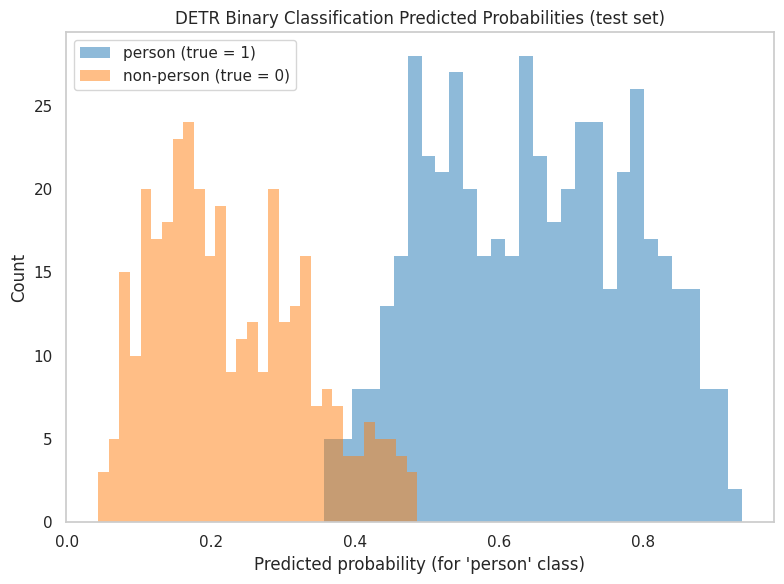

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

person_probs_list = []
nonperson_probs_list = []

for item in all_results:
    # apply Softmax to turn raw logits into probabilities
    probs = item["raw_logits"].softmax(-1)

    # we want the probability of being a "Person" (Class 1)
    person_col_probs = probs[:, 1]

    # gather scores for things predicted as Person
    is_person = probs.argmax(-1) == 1
    person_probs_list.extend(person_col_probs[is_person].tolist())

    # gather scores for things predicted as Person-Like (Class 0)
    is_nonperson = probs.argmax(-1) == 0
    nonperson_probs_list.extend(person_col_probs[is_nonperson].tolist())

plt.figure(figsize=(8, 6))
plt.hist(person_probs_list, bins=30, alpha=0.5, label='person (true = 1)', color='tab:blue', edgecolor='none')
plt.hist(nonperson_probs_list, bins=30, alpha=0.5, label='non-person (true = 0)', color='tab:orange', edgecolor='none')

plt.xlabel("Predicted probability (for 'person' class)")
plt.ylabel("Count")
plt.legend()
plt.title("DETR Binary Classification Predicted Probabilities (test set)")
plt.tight_layout()

plt.grid(False)

plt.savefig(os.path.join(RESULTS_DIR, "confidence_histogram.png"))
plt.show()

In [ ]:
import torch
import numpy as np
from scipy.optimize import linear_sum_assignment

def filter_results_by_class(results, target_class_id):
    """
    Creates a temporary results list containing ONLY objects of a specific class.
    Useful for calculating metrics per-class.
    """
    filtered_results = []
    for item in results:
        # Filter Predictions
        p = item["pred"]
        keep_pred = p["labels"] == target_class_id

        filtered_pred = {
            "boxes": p["boxes"][keep_pred],
            "scores": p["scores"][keep_pred],
            "labels": p["labels"][keep_pred]
        }

        # Filter Ground Truth
        g = item["gt"]
        keep_gt = g["labels"] == target_class_id

        filtered_gt = {
            "boxes": g["boxes"][keep_gt],
            "labels": g["labels"][keep_gt]
        }

        filtered_results.append({"pred": filtered_pred, "gt": filtered_gt})
    return filtered_results

def calculate_metrics_for_subset(subset_results, conf_thresh=0.5):
    TP, FP, FN = 0, 0, 0

    for item in subset_results:
        # Get high-confidence predictions
        p = item["pred"]
        keep = p["scores"] > conf_thresh
        pred_boxes = p["boxes"][keep]

        gt_boxes = item["gt"]["boxes"]

        if len(pred_boxes) == 0:
            FN += len(gt_boxes)
            continue
        if len(gt_boxes) == 0:
            FP += len(pred_boxes)
            continue

        # IoU Matrix
        iou_matrix = np.zeros((len(pred_boxes), len(gt_boxes)))
        for i, pb in enumerate(pred_boxes):
            for j, gb in enumerate(gt_boxes):
                xA = max(pb[0], gb[0])
                yA = max(pb[1], gb[1])
                xB = min(pb[2], gb[2])
                yB = min(pb[3], gb[3])
                inter = max(0, xB - xA) * max(0, yB - yA)
                b1 = (pb[2]-pb[0])*(pb[3]-pb[1])
                b2 = (gb[2]-gb[0])*(gb[3]-gb[1])
                iou_matrix[i, j] = inter / (b1 + b2 - inter + 1e-6)

        # Match
        row_ind, col_ind = linear_sum_assignment(-iou_matrix)

        matched_gt_indices = set()
        for r, c in zip(row_ind, col_ind):
            if iou_matrix[r, c] >= 0.5: # Standard IoU threshold
                TP += 1
                matched_gt_indices.add(c)
            else:
                FP += 1

        FP += (len(pred_boxes) - len(row_ind))
        FN += (len(gt_boxes) - len(matched_gt_indices))

    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-9)

    return precision, recall, f1, TP, FP, FN

classes = {0: "Person-like", 1: "Person"}
conf_threshold = 0.5

print(f"\n PER-CLASS METRICS (Conf Thresh={conf_threshold})")

for class_id, class_name in classes.items():
    # A. Filter data to only look at this class
    subset = filter_results_by_class(all_results, class_id)

    # B. Calculate F1/Precision/Recall
    prec, rec, f1, tp, fp, fn = calculate_metrics_for_subset(subset, conf_threshold)

    # C. Get mAP (Available from your previous torchmetrics run)
    # Note: map_per_class returns a tensor, index matches sorted class IDs
    # If mAP_results is from the previous step:
    try:
        class_map = mAP_results['map_per_class'][class_id].item()
    except:
        class_map = 0.0 # Handle if mAP wasn't computed previously

    print(f"--- CLASS: {class_name.upper()} ---")
    print(f"  mAP (IoU=.5:.95): {class_map:.4f}")
    print(f"  F1 Score:         {f1:.4f}")
    print(f"  Precision:        {prec:.4f}")
    print(f"  Recall:           {rec:.4f}")
    print(f"  (TP={tp}, FP={fp}, FN={fn})")
    print("")


========== PER-CLASS METRICS (Conf Thresh=0.5) ==========
--- CLASS: PERSON-LIKE ---
  mAP (IoU=.5:.95): 0.3055
  F1 Score:         0.5918
  Precision:        0.6172
  Recall:           0.5683
  (TP=158, FP=98, FN=120)

--- CLASS: PERSON ---
  mAP (IoU=.5:.95): 0.2921
  F1 Score:         0.6041
  Precision:        0.5368
  Recall:           0.6909
  (TP=219, FP=189, FN=98)




========== FALSE POSITIVE RATES (CONFUSION) ==========
Confusing 'Person-Like' as 'Person': 8.99%
Confusing 'Person' as 'Person-Like': 6.31%
----------------------------------------------------
Interpretation: 9.0% of your 'Person-like' objects
were incorrectly detected as Humans.


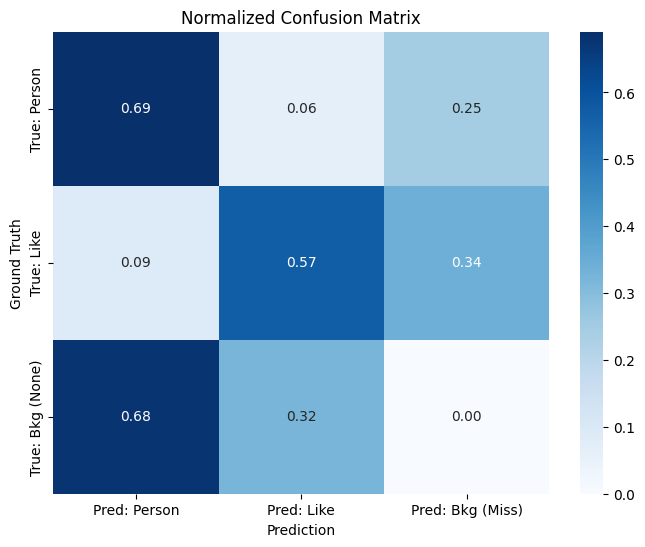

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

def calculate_confusion_matrix(results, conf_threshold=0.5, iou_threshold=0.5):
    # Classes: 0="Person-like", 1="Person", 2="Background" (for missed/hallucinated)
    # We will build lists of [y_true, y_pred] to feed into sklearn
    y_true_all = []
    y_pred_all = []

    # counters for specific class-on-class errors
    person_like_gt_count = 0
    person_like_confused_as_person = 0

    person_gt_count = 0
    person_confused_as_person_like = 0

    for item in results:
        # filter predictions
        p = item["pred"]
        keep = p["scores"] > conf_threshold
        pred_boxes = p["boxes"][keep].numpy()
        pred_labels = p["labels"][keep].numpy()

        gt_boxes = item["gt"]["boxes"].numpy()
        gt_labels = item["gt"]["labels"].numpy()

        person_like_gt_count += np.sum(gt_labels == 0)
        person_gt_count += np.sum(gt_labels == 1)

        if len(pred_boxes) == 0:
            y_true_all.extend(gt_labels)
            y_pred_all.extend([2] * len(gt_labels))
            continue

        if len(gt_boxes) == 0:
            y_true_all.extend([2] * len(pred_boxes))
            y_pred_all.extend(pred_labels)
            continue

        lt = np.maximum(pred_boxes[:, None, :2], gt_boxes[None, :, :2])
        rb = np.minimum(pred_boxes[:, None, 2:], gt_boxes[None, :, 2:])
        wh = np.maximum(0, rb - lt)
        inter = wh[:, :, 0] * wh[:, :, 1]

        area_pred = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
        area_gt = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
        union = area_pred[:, None] + area_gt[None, :] - inter
        iou_matrix = inter / (union + 1e-6)

        row_ind, col_ind = linear_sum_assignment(-iou_matrix)

        matched_gt = set()
        matched_pred = set()

        for p_idx, g_idx in zip(row_ind, col_ind):
            if iou_matrix[p_idx, g_idx] >= iou_threshold:

                g_lbl = gt_labels[g_idx]
                p_lbl = pred_labels[p_idx]

                y_true_all.append(g_lbl)
                y_pred_all.append(p_lbl)

                if g_lbl == 0 and p_lbl == 1:
                    person_like_confused_as_person += 1
                elif g_lbl == 1 and p_lbl == 0:
                    person_confused_as_person_like += 1

                matched_gt.add(g_idx)
                matched_pred.add(p_idx)
            else:
                pass

        # GTs we missed (FNs), labeled as Background (2)
        for g_idx in range(len(gt_boxes)):
            if g_idx not in matched_gt:
                y_true_all.append(gt_labels[g_idx])
                y_pred_all.append(2) # 2 = Background

        # preds that hit nothing (False Positives), GT was Background (2)
        for p_idx in range(len(pred_boxes)):
            if p_idx not in matched_pred:
                y_true_all.append(2) # 2 = Background
                y_pred_all.append(pred_labels[p_idx])

    return {
        "y_true": y_true_all,
        "y_pred": y_pred_all,
        "counts": {
            "person_like_total": person_like_gt_count,
            "person_like_fp": person_like_confused_as_person,
            "person_total": person_gt_count,
            "person_fp": person_confused_as_person_like
        }
    }

cm_data = calculate_confusion_matrix(all_results, conf_threshold=0.5)

fpr_person = cm_data["counts"]["person_like_fp"] / (cm_data["counts"]["person_like_total"] + 1e-6)

fpr_person_like = cm_data["counts"]["person_fp"] / (cm_data["counts"]["person_total"] + 1e-6)

print("FALSE POSITIVE RATES (CONFUSION)")
print(f"Confusing 'Person-Like' as 'Person': {fpr_person:.2%}")
print(f"Confusing 'Person' as 'Person-Like': {fpr_person_like:.2%}")
print(f"Interpretation: {fpr_person*100:.1f}% of your 'Person-like' objects")
print("were incorrectly detected as Humans.")

# Labels: 0=Person-Like, 1=Person, 2=Background
cm = confusion_matrix(cm_data["y_true"], cm_data["y_pred"], labels=[1, 0, 2])

# Normalize by row (True Label) to see recall/miss rates
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=['Pred: Person', 'Pred: Like', 'Pred: Bkg (Miss)'],
            yticklabels=['True: Person', 'True: Like', 'True: Bkg (None)'])
plt.title("Normalized Confusion Matrix")
plt.ylabel('Ground Truth')
plt.xlabel('Prediction')
plt.show()